<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/MLP_garret_JAX_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [3]:
## Importação do histórico - UNISIM
df = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim.xlsx')
df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [4]:
df.shape

(132, 11)

In [5]:
## Importação do histórico - UNISIM - vazões
df2 = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim_rate.xlsx')
df2.head()

,t,qo,qg,qw,qwinj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,1998,221228,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,2015,215295,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,1934,219341,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,2014,217558,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [6]:
df2.index = df2['t']
# df2.drop(df.columns[:5], axis=1, inplace=True)
df2.drop('t', axis=1, inplace=True)
df2.drop('Rs', axis=1, inplace=True)
df2.drop('Viso', axis=1, inplace=True)
df2.drop('Visg', axis=1, inplace=True)
df2.head()

,qo,qg,qw,qwinj,Bo,Bg,p
t,,,,,,,
0,0,0,0,0,1.394241,0.003249,332
31,1998,221228,0,0,1.394403,0.003260,331
62,2015,215295,0,0,1.394727,0.003281,329
92,1934,219341,0,0,1.394889,0.003291,328
123,2014,217558,0,0,1.395051,0.003302,327


In [7]:
df2["p_ant"]=df2["p"].shift(1).fillna(df["p"].values[0])
df2.drop('p', axis=1, inplace=True)
df2["p"]=df["p"].values
df2.tail()

,qo,qg,qw,qwinj,Bo,Bg,p_ant,p
t,,,,,,,,
3867,9053,986609,6446,19374,1.398615,0.003554,304.0,305
3896,9116,1003676,6552,21068,1.398453,0.003542,305.0,306
3927,9090,1013683,6635,20900,1.398291,0.003530,306.0,307
3957,8777,997947,6738,19286,1.398129,0.003518,307.0,308
3988,8549,973332,6933,20607,1.397967,0.003506,308.0,309


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Separar as características e o rótulo
features = df2.iloc[:, :-1]  # Todas as colunas exceto a última
# features = df2.iloc[:, 1:-1]  # Todas as colunas menos a última e a primeira (t)
labels = df2.iloc[:, -1]     # Última coluna

# Normalizar as características
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Combinar as características normalizadas e a coluna de rótulos não normalizada
scaled_data = np.concatenate([scaled_features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = np.concatenate([features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = df2.to_numpy()

scaled_data.shape, scaled_data[0], labels

((132, 8),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   1., 332.]),
 t
 0       332
 31      331
 62      329
 92      328
 123     327
        ... 
 3867    305
 3896    306
 3927    307
 3957    308
 3988    309
 Name: p, Length: 132, dtype: int64)

In [9]:
# Dicionários para armazenar X e y para cada valor de window_size
datasets = {}

# Gerar os datasets X e y para cada valor de window_size de 1 a 6
for window_size in range(1, 7):
    X = []
    y = []
    for i in range(len(scaled_data) - window_size):
        seq = scaled_data[i:i + window_size][:, :-1]
        label = scaled_data[i + window_size - 1][-1]
        X.append(seq)
        y.append(label)

    # Convertendo para arrays do JAX e armazenando no dicionário
    datasets[window_size] = {
        'X': jnp.array(X),
        'y': jnp.array(y)
    }

In [10]:
# Exemplo de acesso aos dados para window_size = 3
datasets[3]['X'].shape, datasets[3]['y'].shape

((129, 3, 7), (129,))

In [11]:
window_size = 1

X = datasets[window_size]['X']
y = datasets[window_size]['y']
X.shape, y.shape

((131, 1, 7), (131,))

In [12]:
X[0], y[0]

(Array([[0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 Array(332., dtype=float32))

In [13]:
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
X[0]

Array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [14]:
X.shape, y.shape

((131, 7), (131,))

In [15]:
test_size = 24
val_size = 12
train_size = len(X) - test_size - val_size
train_size, val_size, test_size

(95, 12, 24)

In [16]:
X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X_train, y_train
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
# X_test, y_test = X[train_size:], y[train_size:]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
# X_train, X_val, X_test = X, X, X
# y_train, y_val, y_test = y, y, y
X_trainval, y_trainval = X[:train_size+val_size], y[:train_size+val_size]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_trainval.shape, y_trainval.shape

((95, 7), (95,), (12, 7), (12,), (24, 7), (24,), (107, 7), (107,))

In [17]:
X_train[0], y_train[0]

(Array([0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 Array(332., dtype=float32))

In [18]:
npp=df["Np"].values[window_size:train_size+window_size]
gp=df["Gp"].values[window_size:train_size+window_size]/1000
wp=df["Wp"].values[window_size:train_size+window_size]
winj=df["Winj"].values[window_size:train_size+window_size]
bo=df["Bo"].values[window_size:train_size+window_size]
bg=df["Bg"].values[window_size:train_size+window_size]
rs=df["Rs"].values[window_size:train_size+window_size]
viso=df["Viso"].values[window_size:train_size+window_size]
visg=df["Visg"].values[window_size:train_size+window_size]
p=df["p"].values[window_size:train_size+window_size]
t=df['t'].values[window_size:train_size+window_size]

# npp=df["Np"].values
# gp=df["Gp"].values/1000
# wp=df["Wp"].values
# winj=df["Winj"].values
# bo=df["Bo"].values
# bg=df["Bg"].values
# rs=df["Rs"].values
# viso=df["Viso"].values
# visg=df["Visg"].values
# p=df["p"].values
# t=df['t'].values

In [19]:
p.shape, y_train.shape

((95,), (95,))

In [20]:
# dt = jnp.diff(t)
# dt = jnp.insert(dt, 0, 1)
# qo = jnp.diff(npp)
# qo = jnp.insert(qo, 0, 0)
# qo = qo / dt
# qg = jnp.diff(gp)
# qg = jnp.insert(qg, 0, 0)
# qg = qg / dt
# qw = jnp.diff(wp)
# qw = jnp.insert(qw, 0, 0)
# qw = qw / dt
# qwi = jnp.diff(winj)
# qwi = jnp.insert(qwi, 0, 0)
# qwi = qwi / dt

In [21]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

t0 = df['t'].values[0]
p0 = df["p"].values[0]
Rsi = df["Rs"].values[0]
boi = df["Bo"].values[0]
bgi = df["Bg"].values[0]

t0, p0, Rsi, boi, bgi

(0, 332, 113.06, 1.39424086, 0.003249477045853988)

In [22]:
# Definir a rede MLP usando Flax
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        num_layers = 2
        layer_size = 128
        out_dim = 1

        for _ in range(num_layers):
          x = nn.Dense(layer_size)(x)
          x = nn.relu(x)

        x = nn.Dense(out_dim)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class MLPnet(MLP):
    def setup(self):
        super().setup()
        self.N = self.param("N", jax.nn.initializers.constant(180.0), ())
        self.Wi = self.param("Wi", jax.nn.initializers.constant(100.0), ())
        self.J = self.param("J", jax.nn.initializers.constant(95.0), ())

# Define the Neural Network
model = MLPnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# lr = 0.01
lr = optax.exponential_decay(init_value=1e-3,
                             transition_steps=3000,
                             decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    # apply_fn=model.apply,
    params=params,
    tx=tx)

# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                               MLPnet Summary                                
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLPnet │ float32[7]   │ float32[1]   │ J: float32[]             │
│         │        │              │              │ N: float32[]             │
│         │        │              │              │ Wi: float32[]            │
│         │        │              │              │                          │
│         │        │              │              │ 3 (12 B)                 │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[7]   │ float32[128] │ bias: float32[128]       │
│         │        │              │              │ kernel: float32[7,128]   │
│         │        │              │              │             

In [23]:
# Imprimindo os parametros a serem ajustados
state.params['params']['N'], state.params['params']['Wi'], state.params['params']['J']

(Array(180., dtype=float32),
 Array(100., dtype=float32),
 Array(95., dtype=float32))

The solution for u(x=[0. 0. 0. 0. 0. 0. 1.] = 0.23814547061920166


Text(0.5, 1.0, 'Previsão antes do ajuste do modelo')

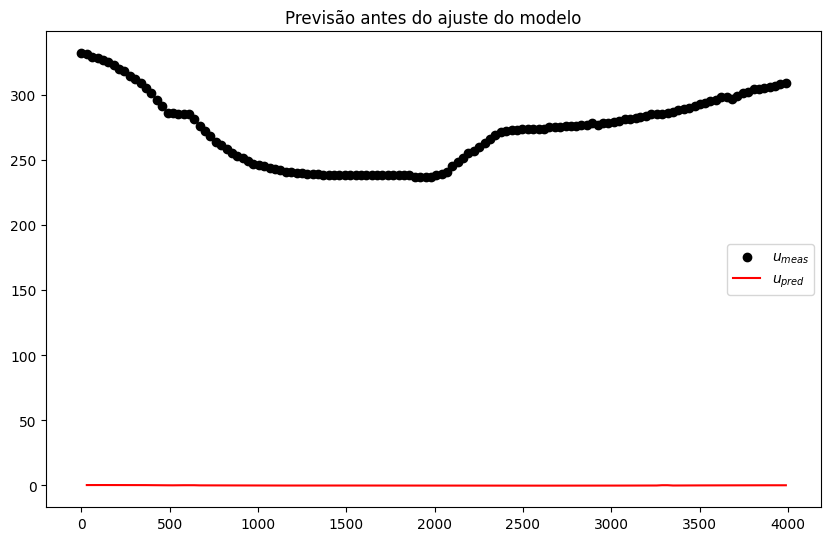

In [24]:
# Avaliando o modelo para um único vetor de entrada
x_single = X_train[0]
u_pred = state.apply_fn(params, x_single)
print(f"The solution for u(x={x_single} = {u_pred}")

# Avaliando a rede neural antes do treinamento considerando todo o histórico
u_pred = vmap(state.apply_fn, (None, 0))(state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(df['t'].values, df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(df["t"].values[window_size:], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão antes do ajuste do modelo')

In [25]:
# Definir loss function
@jit
def train_step(state, batch):
    def phy_residual_fn(params, u):
        # Aplicar limites nos parâmetros
        N = jnp.clip(params['params']['N'], 0.0, 300.0)  # Limita N entre 0 e 300
        Wi = jnp.clip(params['params']['Wi'], 100.0, 1000.0)  # Limita Wi entre 100 e 1000
        J = jnp.clip(params['params']['J'], 1.0, 100.0)  # Limita J entre 1 e 100

        #EBM
        rp = gp  / jnp.where(npp != 0, npp, 1.0) * 1000
        F = npp * (bo + (rp-rs) * bg) + (wp - winj) * Bw
        Eo = bo - boi + (Rsi - rs) * bg
        Eg = boi * ((bg / bgi) - 1)
        Efw = (1 + m) * boi * ((cf + cw * Swi)/(1 - Swi)) * (p0 - u)
        We_EBM = F - (N * 10**6) * (Eo + m * Eg + Efw)

        #Aquif
        Wei = (cf + cw) * Wi * p0 * 10**6
        Wen = jnp.zeros(len(t))
        dt = jnp.diff(t)
        dt = jnp.insert(dt, 0, t[0])
        pa_med = jnp.zeros(len(t))
        pa_med = pa_med.at[0].set(p0)
        for i in range(1,len(t)):
          pa_med = pa_med.at[i-1].set(p0 *(1 - (Wen[i-1] / Wei)))
          Wen = Wen.at[i].set(Wen[i-1] + (Wei / p0) * (pa_med[i-1] - u[i]) * (1 - jnp.exp(-J * p0 * dt[i] / Wei)))

        res = (We_EBM - Wen) / 10**6
        # res = 0.0
        return res

    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        res_pred = phy_residual_fn(params, u_pred)
        phy_loss = jnp.mean(res_pred ** 2) ** 0.5
        data_loss = jnp.mean(jnp.square(u_pred - batch['u']))
        total_loss = 10.0 * data_loss + 1.0 * phy_loss
        return total_loss, {
            "total_loss": total_loss,
            "data_loss": data_loss,
            "phy_loss": phy_loss,
        }

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(
        state.params, batch
    )
    state = state.apply_gradients(grads=grads)
    return loss_components, state

# Definir evaluation function
@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [26]:
## TREINAMENTO ##

# Criar logs de treinamento
total_loss_log = []
data_loss_log = []
phy_loss_log = []
epoch_log = []
error_log = []
N_log = []
Wi_log = []
J_log = []

# Criar batches de treinamento e validação
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

# Criar variável para armazenar o menor erro de validação e o estado correspondente
best_error = float('inf')
best_state = None

# Executar o treinamento da rede neural
epochs = 50_000

for epoch in range(epochs):
  loss, state = train_step(state, train_batch)
  if epoch%1000 == 0:
    epoch_log.append(epoch)
    N_est = state.params["params"]["N"]
    Wi_est = state.params["params"]["Wi"]
    J_est = state.params["params"]["J"]
    total_loss_log.append(loss['total_loss'])
    data_loss_log.append(loss['data_loss'])
    phy_loss_log.append(loss['phy_loss'])
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    N_log.append(N_est)
    Wi_log.append(Wi_est)
    J_log.append(J_est)
    print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.6f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

    # Salvar o estado do modelo com menor erro
    if eval_error < best_error:
        best_error = eval_error
        best_state = state

Epoch: 0 -- Total Loss: 712605.375000  -- Data Loss: 71259.804688 -- Physics Loss: 7.385893 -- Error: 78643.875000 -- N: 180.00 -- Wi: 100.00 -- J: 95.00
Epoch: 1000 -- Total Loss: 109.500412  -- Data Loss: 10.922750 -- Physics Loss: 0.272912 -- Error: 64.576538 -- N: 180.18 -- Wi: 99.99 -- J: 94.81
Epoch: 2000 -- Total Loss: 26.075438  -- Data Loss: 2.583486 -- Physics Loss: 0.240580 -- Error: 34.109322 -- N: 180.95 -- Wi: 99.99 -- J: 95.29
Epoch: 3000 -- Total Loss: 17.902016  -- Data Loss: 1.767272 -- Physics Loss: 0.229301 -- Error: 18.154549 -- N: 181.80 -- Wi: 99.99 -- J: 96.01
Epoch: 4000 -- Total Loss: 13.909838  -- Data Loss: 1.368920 -- Physics Loss: 0.220635 -- Error: 12.205851 -- N: 182.65 -- Wi: 99.99 -- J: 96.86
Epoch: 5000 -- Total Loss: 12.022554  -- Data Loss: 1.180879 -- Physics Loss: 0.213759 -- Error: 9.622059 -- N: 183.46 -- Wi: 99.99 -- J: 97.77
Epoch: 6000 -- Total Loss: 11.070419  -- Data Loss: 1.086155 -- Physics Loss: 0.208869 -- Error: 7.362951 -- N: 184.23 -

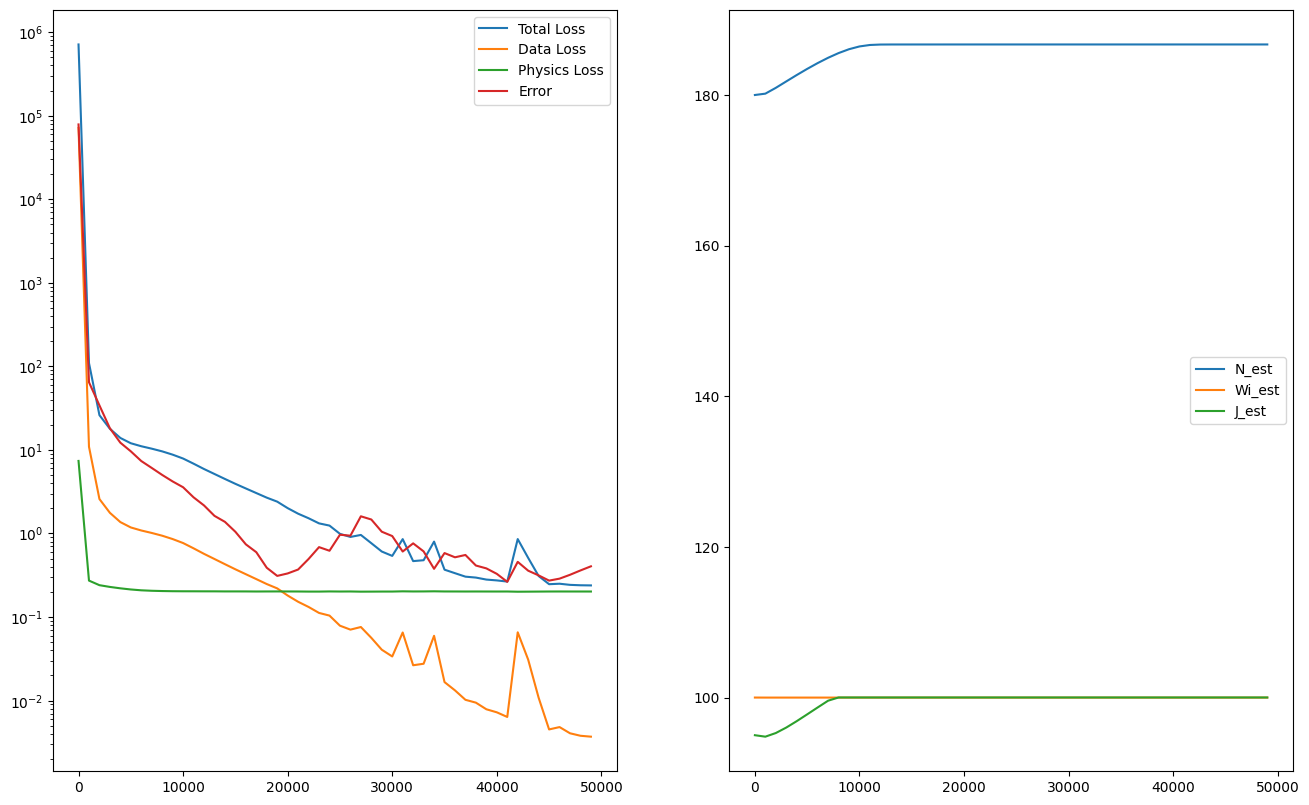

In [27]:
# Plot training & validation loss values
fig, axs = plt.subplots(1, 2, figsize=(16, 16 / 1.618))

axs[0].plot(epoch_log, total_loss_log, label="Total Loss")
axs[0].plot(epoch_log, data_loss_log, label="Data Loss")
axs[0].plot(epoch_log, phy_loss_log, label="Physics Loss")
axs[0].plot(epoch_log, error_log, label="Error")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(epoch_log, N_log, label="N_est")
axs[1].plot(epoch_log, Wi_log, label="Wi_est")
axs[1].plot(epoch_log, J_log, label="J_est")
axs[1].legend()

In [28]:
# Imprimindo os parametros ajustados
best_state.params['params']['N'], best_state.params['params']['Wi'], best_state.params['params']['J']

(Array(186.70938, dtype=float32),
 Array(99.99402, dtype=float32),
 Array(100.008415, dtype=float32))

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict using the trained model
predictions = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 10.60464096069336
Mean Squared Error (MSE): 160.5823516845703
Root Mean Squared Error (RMSE): 12.672109204255237


Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

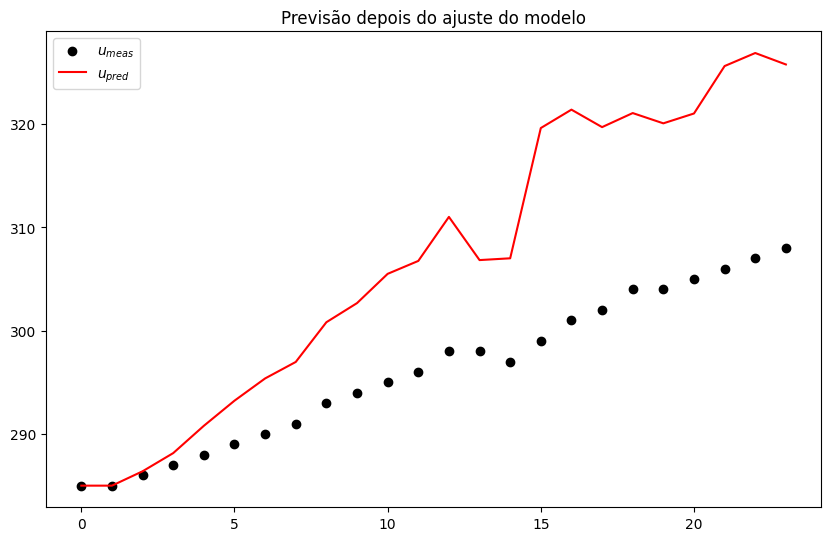

In [30]:
# Avaliando a rede neural depois do treinamento considerando o teste

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(jnp.arange(0, len(y_test), 1), y_test, label=r'$u_{meas}$', color='black')
ax.plot(jnp.arange(0, len(y_test), 1), predictions, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')

Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

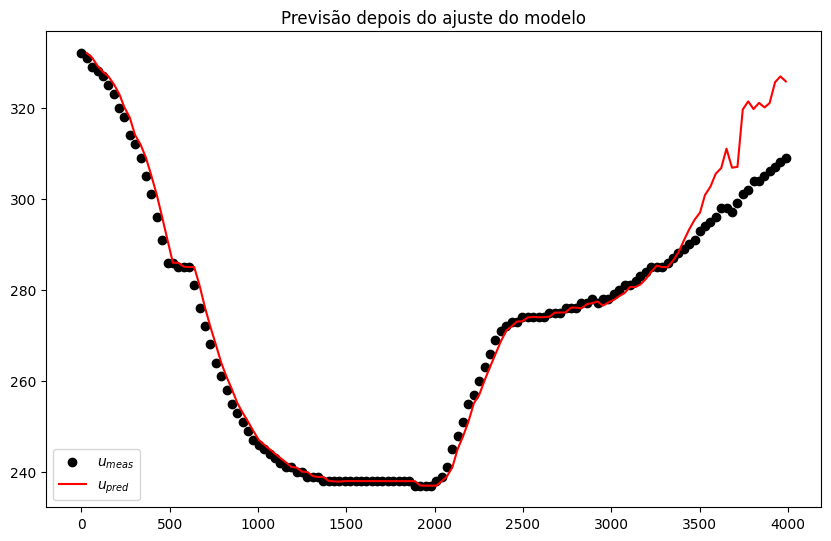

In [31]:
# Avaliando a rede neural depois do treinamento considerando todo o histórico
u_pred = vmap(best_state.apply_fn, (None, 0))(best_state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(df['t'].values, df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(df["t"].values[window_size:], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')

In [32]:
import itertools

# Hiperparâmetros para o grid search
window_sizes = [1, 2, 3]
num_layers_options = [2, 3, 4]
layer_size_options = [128, 256]
num_epochs_options = [50_000]

# Criando todas as combinações possíveis
combinations = list(itertools.product(
        window_sizes, num_layers_options, layer_size_options, num_epochs_options))

# Criando o DataFrame
df_exp = pd.DataFrame(combinations, columns=['window_size', 'num_layers', 'layer_size', 'num_epochs'])

# Cria coluna para os resultados MAE
df_exp['MAE'] = None

df_exp

,window_size,num_layers,layer_size,num_epochs,MAE
0,1,2,128,50000,None
1,1,2,256,50000,None
2,1,3,128,50000,None
3,1,3,256,50000,None
4,1,4,128,50000,None
5,1,4,256,50000,None
6,2,2,128,50000,None
7,2,2,256,50000,None
8,2,3,128,50000,None
9,2,3,256,50000,None


In [33]:
import time

# Estrutura para armazenar o melhor resultado e configuração
best_result = {
    "error": float('inf'),
    "params": None,
    "model_state": None,
    "index": None,
}

inicio_fc = time.time()

# Loop para o grid search
for i in range(len(combinations)):
    window_size, num_layers, layer_size, num_epochs = combinations[i]

    # Preparação dos dados para o `window_size` atual
    X = datasets[window_size]['X']
    y = datasets[window_size]['y']
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))

    # Divisão dos dados em treino, validação e teste
    test_size = 24
    val_size = 12
    train_size = len(X) - test_size - val_size
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    npp=df["Np"].values[window_size:train_size+window_size]
    gp=df["Gp"].values[window_size:train_size+window_size]/1000
    wp=df["Wp"].values[window_size:train_size+window_size]
    winj=df["Winj"].values[window_size:train_size+window_size]
    bo=df["Bo"].values[window_size:train_size+window_size]
    bg=df["Bg"].values[window_size:train_size+window_size]
    rs=df["Rs"].values[window_size:train_size+window_size]
    viso=df["Viso"].values[window_size:train_size+window_size]
    visg=df["Visg"].values[window_size:train_size+window_size]
    p=df["p"].values[window_size:train_size+window_size]
    t=df['t'].values[window_size:train_size+window_size]

    # Definir a rede MLP dinâmica usando Flax
    class MLP(nn.Module):
      @nn.compact
      def __call__(self, x):
          out_dim = 1

          for _ in range(num_layers):
            x = nn.Dense(layer_size)(x)
            x = nn.relu(x)

          x = nn.Dense(out_dim)(x)
          return x

    # Initialize the random key
    rng_key = random.PRNGKey(42)

    class MLPnet(MLP):
      def setup(self):
          super().setup()
          self.N = self.param("N", jax.nn.initializers.constant(180.0), ())
          self.Wi = self.param("Wi", jax.nn.initializers.constant(100.0), ())
          self.J = self.param("J", jax.nn.initializers.constant(95.0), ())

    # Define the Neural Network
    model = MLPnet()

    # Initialize the model parameters
    rng_key, init_key = random.split(rng_key, 2)
    dummy_input = jnp.zeros(X_train[0].shape)
    params = model.init(init_key, dummy_input)

    # Definir o otimizador
    lr = optax.exponential_decay(init_value=1e-3, transition_steps=3000, decay_rate=0.98)
    tx = optax.adam(learning_rate=lr)

    # Create the training state
    state = TrainState.create(
      apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
      # apply_fn=model.apply,
      params=params,
      tx=tx)

    # Criar logs de treinamento
    total_loss_log = []
    data_loss_log = []
    phy_loss_log = []
    epoch_log = []
    error_log = []
    N_log = []
    Wi_log = []
    J_log = []

    # Configurar batches de treino e validação
    train_batch = {'x': X_train, 'u': y_train}
    eval_batch = {'x': X_val, 'u': y_val}

    # Variáveis de controle de melhor erro
    best_error = float('inf')
    best_state = None

    # Treinamento para o número de épocas especificado
    for epoch in range(num_epochs):
        loss, state = train_step(state, train_batch)

        if epoch % 1000 == 0:
            epoch_log.append(epoch)
            N_est = state.params["params"]["N"]
            Wi_est = state.params["params"]["Wi"]
            J_est = state.params["params"]["J"]
            total_loss_log.append(loss['total_loss'])
            data_loss_log.append(loss['data_loss'])
            phy_loss_log.append(loss['phy_loss'])
            eval_error = eval_step(state, eval_batch)
            error_log.append(eval_error)
            N_log.append(N_est)
            Wi_log.append(Wi_est)
            J_log.append(J_est)
            # print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.6f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

            if (epoch > 10_000) and (eval_error < best_error):
                best_error = eval_error
                best_state = state

    # Teste final com o melhor estado encontrado nesta combinação
    predictions = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_test)
    mae = mean_absolute_error(y_test, predictions)
    df_exp.loc[i, 'MAE'] = mae

    # Verificar se esta combinação é a melhor até agora
    if mae < best_result["error"]:
        best_result["error"] = mae
        best_result["params"] = {
            "window_size": window_size,
            "num_layers": num_layers,
            "layer_size": layer_size,
            "num_epochs": num_epochs
        }
        best_result["model_state"] = best_state
        best_result["index"] = i

    print(f"Rodada {i+1}/{len(combinations)}: window_size={window_size}, num_layers={num_layers}, "
          f"layer_size={layer_size}, num_epochs={num_epochs} -- MAE: {mae:.02f}")

fim_fc = time.time()
tempo_fc = fim_fc - inicio_fc
print(f"\nTempo de execução: {tempo_fc:0.2f} segundos")

Rodada 1/18: window_size=1, num_layers=2, layer_size=128, num_epochs=50000 -- MAE: 10.60
Rodada 2/18: window_size=1, num_layers=2, layer_size=256, num_epochs=50000 -- MAE: 1.41
Rodada 3/18: window_size=1, num_layers=3, layer_size=128, num_epochs=50000 -- MAE: 8.46
Rodada 4/18: window_size=1, num_layers=3, layer_size=256, num_epochs=50000 -- MAE: 6.67
Rodada 5/18: window_size=1, num_layers=4, layer_size=128, num_epochs=50000 -- MAE: 1.74
Rodada 6/18: window_size=1, num_layers=4, layer_size=256, num_epochs=50000 -- MAE: 19.25
Rodada 7/18: window_size=2, num_layers=2, layer_size=128, num_epochs=50000 -- MAE: 8.38
Rodada 8/18: window_size=2, num_layers=2, layer_size=256, num_epochs=50000 -- MAE: 1.70
Rodada 9/18: window_size=2, num_layers=3, layer_size=128, num_epochs=50000 -- MAE: 4.43
Rodada 10/18: window_size=2, num_layers=3, layer_size=256, num_epochs=50000 -- MAE: 20.34
Rodada 11/18: window_size=2, num_layers=4, layer_size=128, num_epochs=50000 -- MAE: 13.19
Rodada 12/18: window_size=

In [34]:
df_exp.to_excel('/content/drive/MyDrive/UNISIM/results_pinn_mlp.xlsx', sheet_name='results_MLP', index=False)
df_exp

,window_size,num_layers,layer_size,num_epochs,MAE
0,1,2,128,50000,10.604641
1,1,2,256,50000,1.408915
2,1,3,128,50000,8.458984
3,1,3,256,50000,6.674427
4,1,4,128,50000,1.743234
5,1,4,256,50000,19.251389
6,2,2,128,50000,8.380582
7,2,2,256,50000,1.698545
8,2,3,128,50000,4.431816
9,2,3,256,50000,20.343269


In [35]:
best_result["model_state"].params['params']['N'], best_result["model_state"].params['params']['Wi'], best_result["model_state"].params['params']['J']

(Array(186.6667, dtype=float32),
 Array(99.99402, dtype=float32),
 Array(100.00862, dtype=float32))

In [36]:
best_result["error"], best_result["params"]

(1.4089151620864868,
 {'window_size': 1, 'num_layers': 2, 'layer_size': 256, 'num_epochs': 50000})

In [37]:
window_size, num_layers, layer_size, num_epochs = combinations[best_result["index"]]
window_size, num_layers, layer_size, num_epochs

(1, 2, 256, 50000)

In [38]:
# Preparação dos dados para o `window_size` atual
X = datasets[window_size]['X']
y = datasets[window_size]['y']
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# Divisão dos dados em treino, validação e teste
test_size = 24
train_size = len(X) - test_size
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]
X_test, y_test = X[train_size:], y[train_size:]

npp=df["Np"].values[window_size:train_size+window_size]
gp=df["Gp"].values[window_size:train_size+window_size]/1000
wp=df["Wp"].values[window_size:train_size+window_size]
winj=df["Winj"].values[window_size:train_size+window_size]
bo=df["Bo"].values[window_size:train_size+window_size]
bg=df["Bg"].values[window_size:train_size+window_size]
rs=df["Rs"].values[window_size:train_size+window_size]
viso=df["Viso"].values[window_size:train_size+window_size]
visg=df["Visg"].values[window_size:train_size+window_size]
p=df["p"].values[window_size:train_size+window_size]
t=df['t'].values[window_size:train_size+window_size]

In [39]:
## TREINAMENTO ##

# Criar logs de treinamento
total_loss_log = []
data_loss_log = []
phy_loss_log = []
epoch_log = []
error_log = []
N_log = []
Wi_log = []
J_log = []

# Criar batches de treinamento e validação
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

# Criar variável para armazenar o menor erro de validação e o estado correspondente
best_error = float('inf')
best_state = None
state = best_result["model_state"]

# Executar o treinamento da rede neural
for epoch in range(10_000):
  loss, state = train_step(state, train_batch)
  if epoch%1000 == 0:
    epoch_log.append(epoch)
    N_est = state.params["params"]["N"]
    Wi_est = state.params["params"]["Wi"]
    J_est = state.params["params"]["J"]
    total_loss_log.append(loss['total_loss'])
    data_loss_log.append(loss['data_loss'])
    phy_loss_log.append(loss['phy_loss'])
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    N_log.append(N_est)
    Wi_log.append(Wi_est)
    J_log.append(J_est)
    print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.6f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

    # Salvar o estado do modelo com menor erro
    if (eval_error < best_error):
        best_error = eval_error
        best_state = state

Epoch: 0 -- Total Loss: 4.962437  -- Data Loss: 0.474361 -- Physics Loss: 0.218830 -- Error: 4.462727 -- N: 186.67 -- Wi: 99.99 -- J: 100.01
Epoch: 1000 -- Total Loss: 4.044649  -- Data Loss: 0.382813 -- Physics Loss: 0.216516 -- Error: 11.496714 -- N: 185.71 -- Wi: 99.99 -- J: 100.01
Epoch: 2000 -- Total Loss: 3.717386  -- Data Loss: 0.350291 -- Physics Loss: 0.214473 -- Error: 9.800465 -- N: 185.42 -- Wi: 99.99 -- J: 100.01
Epoch: 3000 -- Total Loss: 3.444179  -- Data Loss: 0.322716 -- Physics Loss: 0.217023 -- Error: 12.273490 -- N: 185.36 -- Wi: 99.99 -- J: 100.01
Epoch: 4000 -- Total Loss: 2.749382  -- Data Loss: 0.253441 -- Physics Loss: 0.214976 -- Error: 10.700686 -- N: 185.36 -- Wi: 99.99 -- J: 100.01
Epoch: 5000 -- Total Loss: 2.404848  -- Data Loss: 0.218950 -- Physics Loss: 0.215353 -- Error: 11.743411 -- N: 185.36 -- Wi: 99.99 -- J: 100.01
Epoch: 6000 -- Total Loss: 2.369857  -- Data Loss: 0.215535 -- Physics Loss: 0.214503 -- Error: 12.399535 -- N: 185.36 -- Wi: 99.99 -- 

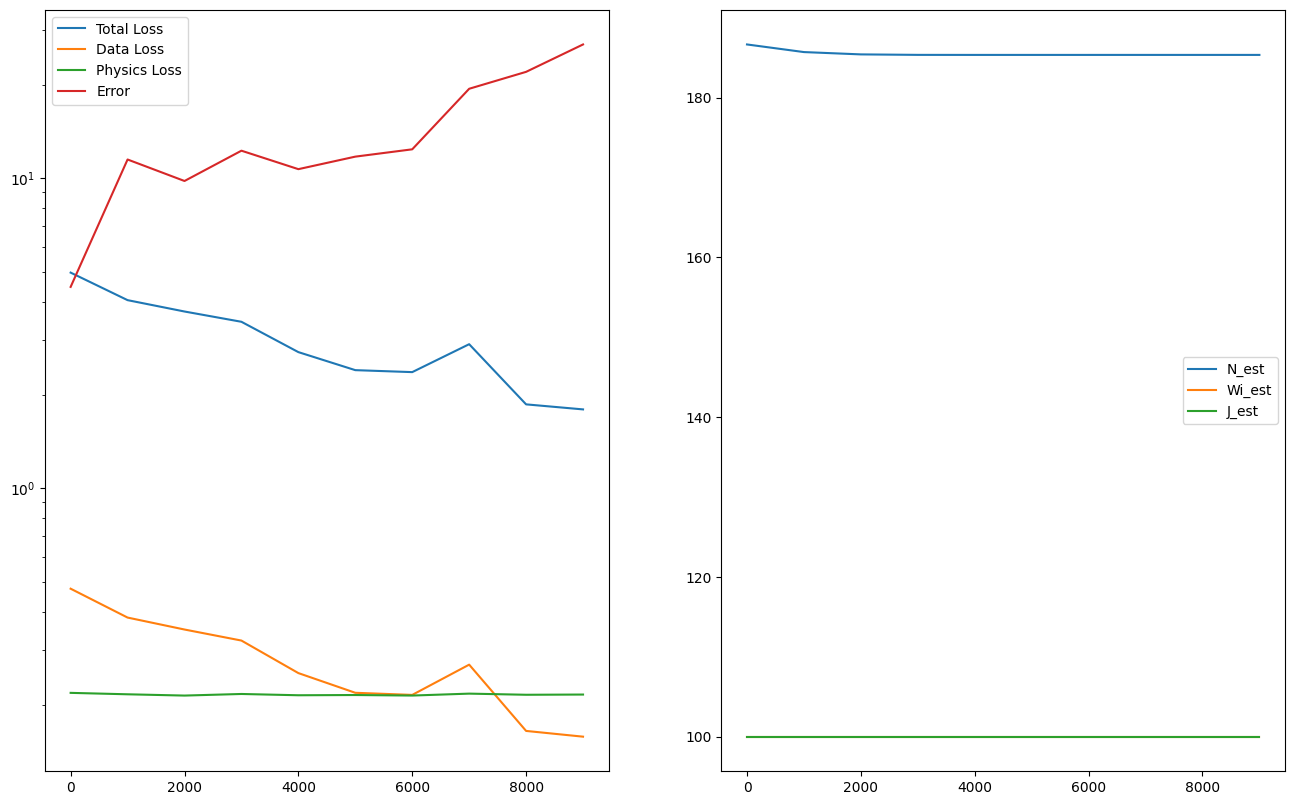

In [40]:
# Plot training & validation loss values
fig, axs = plt.subplots(1, 2, figsize=(16, 16 / 1.618))

axs[0].plot(epoch_log, total_loss_log, label="Total Loss")
axs[0].plot(epoch_log, data_loss_log, label="Data Loss")
axs[0].plot(epoch_log, phy_loss_log, label="Physics Loss")
axs[0].plot(epoch_log, error_log, label="Error")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(epoch_log, N_log, label="N_est")
axs[1].plot(epoch_log, Wi_log, label="Wi_est")
axs[1].plot(epoch_log, J_log, label="J_est")
axs[1].legend()

In [41]:
# Imprimindo os parametros ajustados
best_state.params['params']['N'], best_state.params['params']['Wi'], best_state.params['params']['J']

(Array(186.66655, dtype=float32),
 Array(99.99402, dtype=float32),
 Array(100.00862, dtype=float32))

In [42]:
# Predict using the trained model
predictions = vmap(best_state.apply_fn, (None, 0))(best_state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1.5871366262435913
Mean Squared Error (MSE): 4.462727069854736
Root Mean Squared Error (RMSE): 2.112516762029295


Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

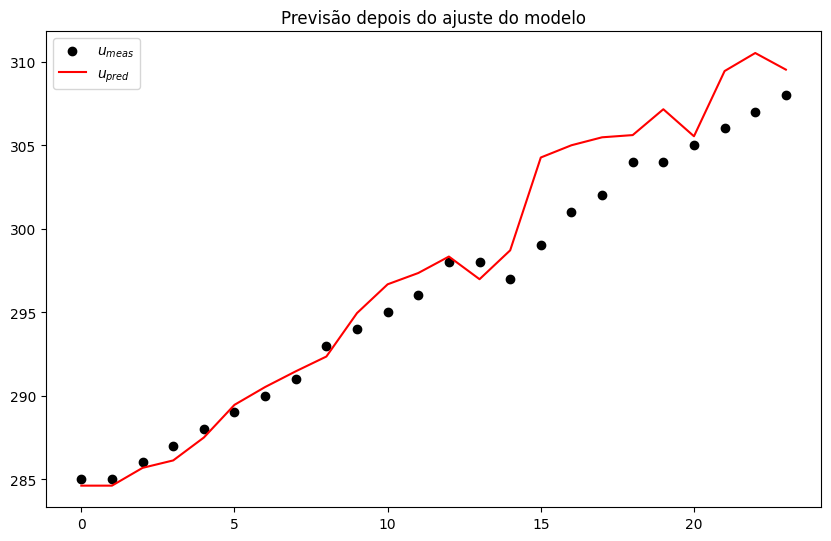

In [43]:
# Avaliando a rede neural depois do treinamento considerando o teste

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(jnp.arange(0, len(y_test), 1), y_test, label=r'$u_{meas}$', color='black')
ax.plot(jnp.arange(0, len(y_test), 1), predictions, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')

Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

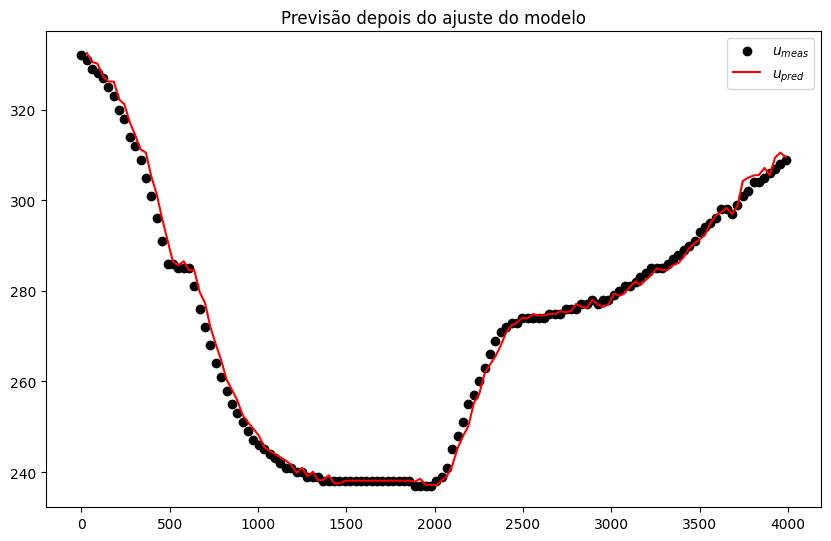

In [44]:
# Avaliando a rede neural depois do treinamento considerando todo o histórico
u_pred = vmap(best_state.apply_fn, (None, 0))(best_state.params, X)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(df['t'].values, df["p"].values, label=r'$u_{meas}$', color='black')
ax.plot(df["t"].values[window_size:], u_pred, label=r'$u_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')